In [1]:
import pandas as pd
import numpy as np
import featuretools as ft
import matplotlib.pyplot as plt
import seaborn as sns
pd.options.display.max_columns=1000
pd.options.display.max_rows=10

In [2]:
app_train = pd.read_csv('C://Users/matth/home-credit-default-risk/application_train.csv').sort_values('SK_ID_CURR').reset_index(drop = True).sample(n=10000)
app_test = pd.read_csv('C://Users/matth/home-credit-default-risk/application_test.csv').sort_values('SK_ID_CURR').reset_index(drop = True).sample(n=10000)

In [3]:
app_train.shape,app_test.shape

((10000, 122), (10000, 121))

In [4]:
app=app_train.append(app_test,ignore_index=True)
app=app.drop("SK_ID_CURR",axis=1)
len(app[app["TARGET"]==0]),len(app[app["TARGET"]==1])

(9203, 797)

In [5]:
categorical_features=app.select_dtypes(include="object").columns
unique_values=[len(app[x].unique()) for x in categorical_features]

In [6]:
label_encoding=pd.DataFrame(data=unique_values,index=categorical_features,columns=["Number of unique"]).\
sort_values(by="Number of unique",ascending=False)[:8].index

In [7]:
get_dummies=pd.DataFrame(data=unique_values,index=categorical_features,columns=["Number of unique"]).\
sort_values(by="Number of unique",ascending=False)[8:].index

In [9]:
pd.DataFrame(data=unique_values,index=categorical_features,columns=["Number of unique"]).\
sort_values(by="Number of unique",ascending=False)[:8]

,Number of unique
ORGANIZATION_TYPE,58
OCCUPATION_TYPE,19
NAME_TYPE_SUITE,8
WALLSMATERIAL_MODE,8
WEEKDAY_APPR_PROCESS_START,7
NAME_HOUSING_TYPE,6
NAME_EDUCATION_TYPE,5
NAME_FAMILY_STATUS,5


In [10]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

for c in label_encoding:
    le.fit(list(app[c].values))
    app[c]=le.transform(list(app[c].values))

In [11]:
app=pd.get_dummies(app,drop_first=True)

In [12]:
correlations=app.corr()["TARGET"]

In [13]:
correlations=pd.DataFrame(correlations)
correlations["TARGET abs"]=abs(correlations["TARGET"])

In [14]:
correlations=correlations.sort_values(by="TARGET abs",ascending=False)

In [15]:
correlations[1:15]

,TARGET,TARGET abs
EXT_SOURCE_2,-0.166583,0.166583
EXT_SOURCE_3,-0.164275,0.164275
EXT_SOURCE_1,-0.153027,0.153027
DAYS_BIRTH,0.070040,0.070040
NAME_INCOME_TYPE_Working,0.063118,0.063118
...,...,...
FLAG_DOCUMENT_3,0.056666,0.056666
REG_CITY_NOT_WORK_CITY,0.053099,0.053099
DEF_30_CNT_SOCIAL_CIRCLE,0.046661,0.046661
WALLSMATERIAL_MODE,0.045481,0.045481


In [16]:
relevant_features=correlations.index[1:15]

In [17]:
missing_data=[app[x].isna().sum()/len(app[x]) for x in relevant_features if app[x].isna().sum()!=0]
missing_cols=[x for x in relevant_features if app[x].isna().sum()!=0]
missing_data=pd.DataFrame(data=missing_data,index=missing_cols,columns=["% of missing data"])
missing_data=missing_data.sort_values(by="% of missing data",ascending=False)
missing_data

,% of missing data
EXT_SOURCE_1,0.49215
EXT_SOURCE_3,0.18750
DEF_30_CNT_SOCIAL_CIRCLE,0.00250
EXT_SOURCE_2,0.00060


In [18]:
ext1_corr=app.corr()["EXT_SOURCE_1"]

In [19]:
abs(pd.DataFrame(ext1_corr)).sort_values(by="EXT_SOURCE_1", ascending=False)

,EXT_SOURCE_1
EXT_SOURCE_1,1.000000
DAYS_BIRTH,0.554090
CODE_GENDER_M,0.292501
FLAG_EMP_PHONE,0.267922
NAME_INCOME_TYPE_Pensioner,0.267922
...,...
FLAG_MOBIL,NaN
FLAG_DOCUMENT_4,NaN
FLAG_DOCUMENT_10,NaN
FLAG_DOCUMENT_12,NaN


In [20]:
missing_ext1_rows= app[app["EXT_SOURCE_1"].isna()].index

In [21]:
#This takes 100 years
for x in missing_ext1_rows:
    app.loc[x,"EXT_SOURCE_1"]=app[(app["DAYS_BIRTH"]==app.loc[x,"DAYS_BIRTH"]) & (app["CODE_GENDER_M"]==app.loc[x,"CODE_GENDER_M"])]\
    ["EXT_SOURCE_1"].median()

C:\Users\matth\anaconda3\envs\Kaggle\lib\site-packages\numpy\lib\nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [22]:
app["EXT_SOURCE_1"].fillna(app["EXT_SOURCE_1"].median(),inplace=True)

In [24]:
ext2_corr=app.corr()["EXT_SOURCE_2"]

In [27]:
abs(pd.DataFrame(ext2_corr)).sort_values(by="EXT_SOURCE_2", ascending=False)

,EXT_SOURCE_2
EXT_SOURCE_2,1.000000
REGION_RATING_CLIENT,0.310313
REGION_RATING_CLIENT_W_CITY,0.306119
DAYS_LAST_PHONE_CHANGE,0.213020
REGION_POPULATION_RELATIVE,0.209734
...,...
AMT_REQ_CREDIT_BUREAU_WEEK,0.000326
FLAG_MOBIL,NaN
FLAG_DOCUMENT_10,NaN
FLAG_DOCUMENT_12,NaN


In [28]:
missing_ext2_rows= app[app["EXT_SOURCE_2"].isna()].index

In [29]:
#This takes 100 years
for x in missing_ext2_rows:
    app.loc[x,"EXT_SOURCE_2"]=app[(app["REGION_RATING_CLIENT"]==app.loc[x,"REGION_RATING_CLIENT"]) & (app["REGION_RATING_CLIENT_W_CITY"]==app.loc[x,"REGION_RATING_CLIENT_W_CITY"])]\
    ["EXT_SOURCE_2"].median()

In [30]:
missing_cols=[x for x in relevant_features if app[x].isna().sum()!=0]
for x in missing_cols:
    app[x].fillna(app[x].median(),inplace=True)

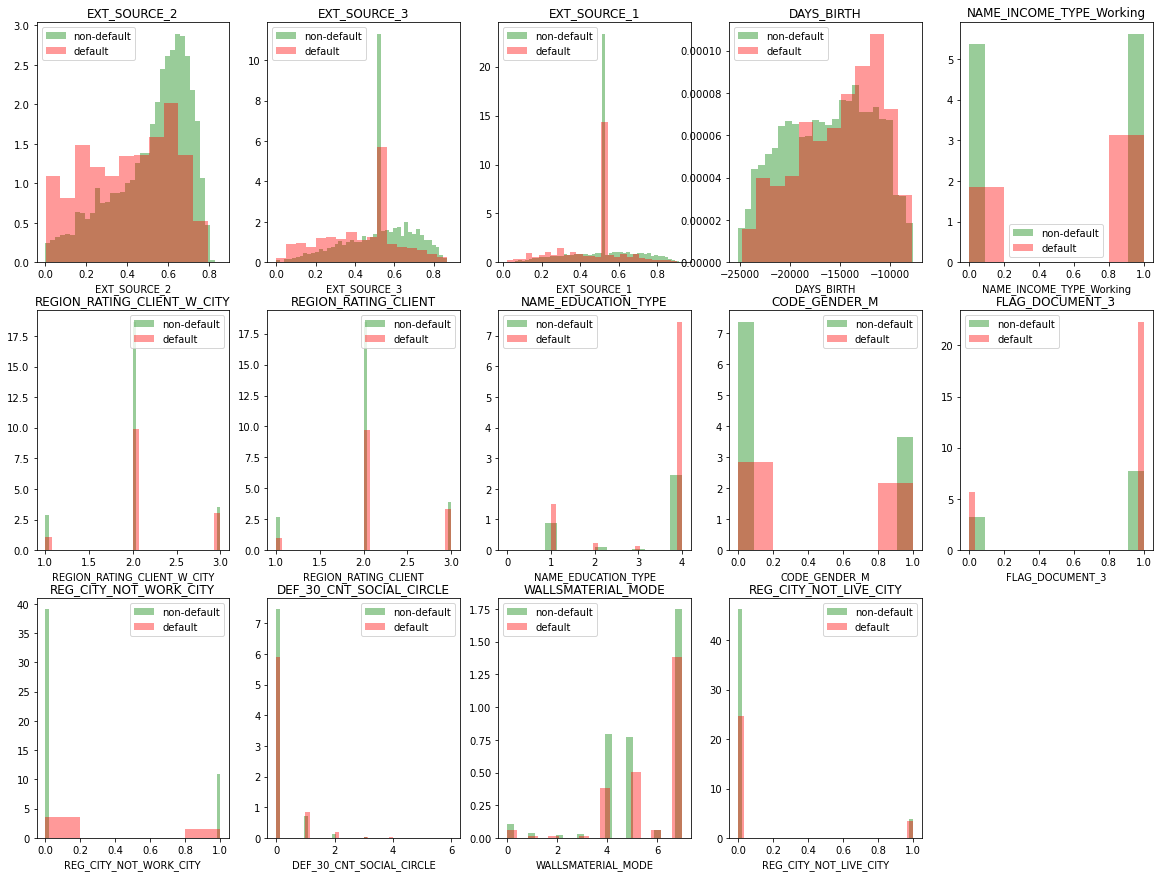

In [33]:
plt.figure(figsize=(20,15))
counter=1
for x in relevant_features:
    plt.subplot(3,5,counter)
    sns.distplot(app[app["TARGET"]==0][x],color="g",label="non-default",kde=False,norm_hist=True)
    sns.distplot(app[app["TARGET"]==1][x],color="r",label="default",kde=False,norm_hist=True)
    plt.legend()
    plt.title(x)
    counter+=1

In [34]:
ntrain=app["TARGET"].isna().sum()
y=app["TARGET"][:ntrain]
X=app[relevant_features][:ntrain]

In [43]:
from sklearn.preprocessing import StandardScaler,RobustScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler=StandardScaler()
X_train=scaler.fit_transform(X_train)
X_test=scaler.transform(X_test)

(<matplotlib.axes._subplots.AxesSubplot at 0x1e94564f848>,
 Text(0.5, 1.0, 'Kbest scores'))

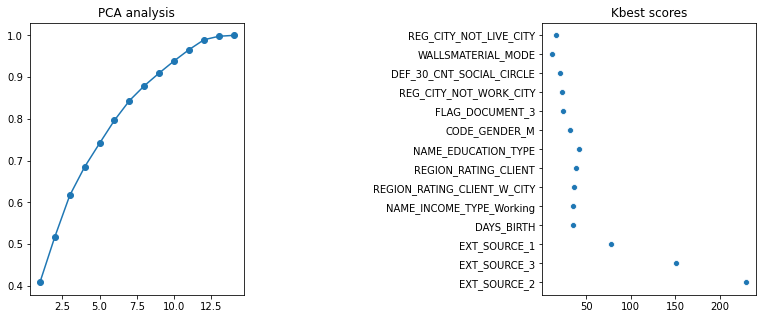

In [44]:
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest
pca=PCA()
pca.fit(X_train)
plt.figure(figsize=(13,5))
components=range(1,len(pca.explained_variance_ratio_)+1)
plt.subplot(1,3,1)
plt.plot(components,pca.explained_variance_ratio_.cumsum(),marker='o'),plt.title("PCA analysis")
kbest=SelectKBest(k="all")
kbest.fit(X_train,y_train)
plt.subplot(1,3,3)
sns.scatterplot(kbest.scores_,relevant_features),plt.title("Kbest scores")
#I will use all relevant features for now

In [49]:
pca=PCA(n_components=10)
X_train_pca=pca.fit_transform(X_train)
X_test_pca=pca.transform(X_test)

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
import lightgbm as lgb

lr=LogisticRegression()
svc=SVC(probability=True)
knn=KNeighborsClassifier()
dtr=DecisionTreeClassifier()
rfc=RandomForestClassifier()

models={"Logistic regression":lr,"Support vector classifier": svc,"K neighbours classifier":knn, \
       "Decision tree classifier": dtr, "Random forest classifier": rfc}

In [51]:
base_model_scores=pd.DataFrame(index=models.keys(),columns=[["training score","ROC AUC"]])
for key,model in models.items():
    model.fit(X_train_pca,y_train)
    train_score=cross_val_score(model,X_train_pca,y_train)
    pred=model.predict_proba(X_test_pca)[:,1]
    roc=roc_auc_score(y_test,pred)
    base_model_scores.loc[key,"training score"]=train_score.mean()
    base_model_scores.loc[key,"ROC AUC"]=roc
base_model_scores

,training score,ROC AUC
Logistic regression,0.921375,0.713038
Support vector classifier,0.921625,0.560431
K neighbours classifier,0.91775,0.626275
Decision tree classifier,0.857125,0.53269
Random forest classifier,0.92075,0.671718


In [52]:
p1=lr.predict_proba(X_test_pca)[:,1]
p2=svc.predict_proba(X_test_pca)[:,1]
p3=knn.predict_proba(X_test_pca)[:,1]
p4=dtr.predict_proba(X_test_pca)[:,1]
p5=rfc.predict_proba(X_test_pca)[:,1]

p_ave=(p1+p2+p3+p4+p5)/5
roc_auc_score(y_test,p_ave)

0.682189006750241

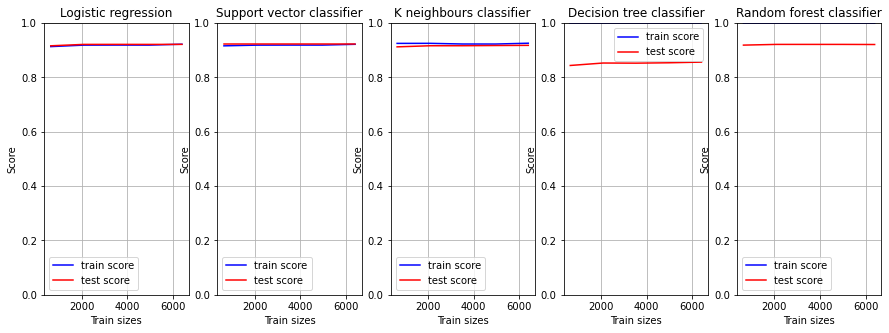

In [53]:
from sklearn.model_selection import learning_curve
x=1
plt.figure(figsize=(15,5))
for key, model in models.items():
    train_sizes, train_scores, test_scores=learning_curve(model,X_train_pca,y_train)
    plt.subplot(1,5,x)
    plt.plot(train_sizes,train_scores.mean(axis=1),color="b",label="train score")
    plt.plot(train_sizes,test_scores.mean(axis=1),color="r",label="test score")
    plt.xlabel("Train sizes"),plt.ylabel("Score"),plt.grid(True),plt.legend(loc="best"),plt.ylim((0,1)),plt.title(key)

    x=x+1

In [314]:
base_model_scores

,training score,ROC AUC
Logistic regression,0.923,0.736912
Support vector classifier,0.9235,0.639838
K neighbours classifier,0.91675,0.573262
Decision tree classifier,0.8575,0.546448
Random forest classifier,0.923,0.664598


In [161]:
def objective(model,hyperparameters,iteration):
    cv_results=cross_val_score(model,X_train_pca,y_train).mean()
    model.fit(X_train_pca,y_train)
    pred=model.predict_proba(X_test_pca)[:,1]
    roc=roc_auc_score(y_test,pred)
    
    return (cv_results,roc,hyperparameters)


In [61]:
lr_param_grid={"penalty": ['l1','l2','elasticnet','none'],
           "C": [0.001,0.01,0.1,1,10]}
rfc_param_grid={"n_estimators":[int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)],
                "criterion": ['gini','entropy'],
                "max_features":["auto", "sqrt", "log2"],
                "boostrap": [True,False]}


In [217]:
import itertools
def grid_search(model,param_grid):
    t0=time.time()
    results=pd.DataFrame(columns=["training score","test ROC AUC","Hyperparameters"])
    keys,values=zip(*param_grid.items())
    i=0
    for v in itertools.product(*values):
        hyperparameters=dict(zip(keys,v))
        eval_results=objective(model,hyperparameters,i)
        results.loc[i,:]=eval_results
        t1=time.time()-t0
        print(t1)
        t1=t0
        i+=1
        if i>2:
            break
    results.sort_values("test ROC AUC",ascending=False,inplace=True)
    results.reset_index(inplace=True,drop=True)
    return results

In [241]:
#Seems like adjusting logistic regression hyperparameters has minimal impact on the results
grid_results=grid_search(lr,lr_param_grid)
grid_results

0.06482458114624023
0.13364076614379883
0.18350768089294434


,training score,test ROC AUC,Hyperparameters
0,0.921375,0.713038,"{'penalty': 'l1', 'C': 0.001}"
1,0.921375,0.713038,"{'penalty': 'l1', 'C': 0.01}"
2,0.921375,0.713038,"{'penalty': 'l1', 'C': 0.1}"


In [216]:
grid_search(rfc,rfc_param_grid)

8.511312007904053
17.045880794525146
25.92547035217285
34.80424928665161
43.64506673812866
52.000192642211914


,training score,test ROC AUC,Hyperparameters
0,0.92075,0.689526,"{'n_estimators': 200, 'criterion': 'gini', 'ma..."
1,0.921,0.687017,"{'n_estimators': 200, 'criterion': 'gini', 'ma..."
2,0.920625,0.686553,"{'n_estimators': 200, 'criterion': 'gini', 'ma..."
3,0.920625,0.68465,"{'n_estimators': 200, 'criterion': 'gini', 'ma..."
4,0.92175,0.680193,"{'n_estimators': 200, 'criterion': 'gini', 'ma..."
5,0.92075,0.674428,"{'n_estimators': 200, 'criterion': 'gini', 'ma..."


In [227]:
import random
def random_grid_search(model,param_grid):
    t0=time.time()
    results=pd.DataFrame(columns=["training score","test ROC AUC","Hyperparameters"])
    keys,values=zip(*param_grid.items())
    
    for i in range(5):
        hyperparameters={k:random.sample(v,1)[0] for k,v in param_grid.items()}
        eval_results=objective(model,hyperparameters,i)
        results.loc[i,:]=eval_results
        t1=time.time()-t0
        print(t1)
        t1=t0
    results.sort_values("test ROC AUC",ascending=False,inplace=True)
    results.reset_index(inplace=True,drop=True)
    return results

In [240]:
random_grid_search(rfc,rfc_param_grid)

9.436345338821411
18.57025122642517
27.529715538024902
36.35640907287598
45.21444082260132


,training score,test ROC AUC,Hyperparameters
0,0.9215,0.689426,"{'n_estimators': 2000, 'criterion': 'entropy',..."
1,0.920375,0.687589,"{'n_estimators': 800, 'criterion': 'gini', 'ma..."
2,0.9205,0.683312,"{'n_estimators': 600, 'criterion': 'gini', 'ma..."
3,0.92075,0.680755,"{'n_estimators': 1000, 'criterion': 'gini', 'm..."
4,0.921,0.671339,"{'n_estimators': 200, 'criterion': 'entropy', ..."


In [230]:
grid_results=random_grid_search(rfc,rfc_param_grid)
grid_results["Hyperparameters"]

8.91926908493042
17.566015243530273
26.588122606277466
35.36103796958923
44.801660776138306


0    {'n_estimators': 1400, 'criterion': 'gini', 'm...
1    {'n_estimators': 200, 'criterion': 'gini', 'ma...
2    {'n_estimators': 1400, 'criterion': 'entropy',...
3    {'n_estimators': 1400, 'criterion': 'gini', 'm...
4    {'n_estimators': 200, 'criterion': 'gini', 'ma...
Name: Hyperparameters, dtype: object

In [239]:
for x,y in zip(grid_results["Hyperparameters"],grid_results["test ROC AUC"]):
    print(x,y)

{'n_estimators': 1400, 'criterion': 'gini', 'max_features': 'log2', 'boostrap': True} 0.690221793635487
{'n_estimators': 200, 'criterion': 'gini', 'max_features': 'auto', 'boostrap': True} 0.6877611700417873
{'n_estimators': 1400, 'criterion': 'entropy', 'max_features': 'auto', 'boostrap': False} 0.6855239472838316
{'n_estimators': 1400, 'criterion': 'gini', 'max_features': 'auto', 'boostrap': True} 0.6837929926068786
{'n_estimators': 200, 'criterion': 'gini', 'max_features': 'sqrt', 'boostrap': False} 0.6815380906460944
